In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [2]:
import dataloader
import utils
import cnnlstm
from utils import mae, rmse

import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, RepeatVector
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# Model Data range
date = datetime.datetime(2021,3,12)
# Total entry count
count = 1200
# Training entry count
training_count = 1000
history_size = 90

%load_ext autoreload
%autoreload 2

# Amazon

In [3]:
path = "../032721Comparison/Data/AMZN2021.csv"
# Load data
train_x, train_y, test_x, test_y = utils.get_train_and_test_set(
    path, date, count, history_size, training_count
)

(1258, 7)
(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)
(910, 90, 1)
(200, 90, 1)


In [4]:
unit_params = range(30, 60, 5)
filter_params = [2, 4, 8, 16, 32]
kernel_params = [2, 4, 8, 16]
best_config, best_err = cnnlstm.cnnlstm_model_selection(train_x, train_y, unit_params, filter_params, kernel_params)
print(best_config, best_err)

2 2 30 mean val RMSE: 0.06799031488174193
2 2 35 mean val RMSE: 0.0877153935924744
2 2 40 mean val RMSE: 0.062096234405528486
2 2 45 mean val RMSE: 0.10617858698851652
2 2 50 mean val RMSE: 0.05124073432654889
2 2 55 mean val RMSE: 0.055682034145786305
2 4 30 mean val RMSE: 0.11022018758349836
2 4 35 mean val RMSE: 0.1467840343481392
2 4 40 mean val RMSE: 0.0699176077570934
2 4 45 mean val RMSE: 0.03397135160395598
2 4 50 mean val RMSE: 0.06280696981591657
2 4 55 mean val RMSE: 0.11138337822842251
2 8 30 mean val RMSE: 0.08577699793271845
2 8 35 mean val RMSE: 0.08220234777124477
2 8 40 mean val RMSE: 0.10706752480322179
2 8 45 mean val RMSE: 0.060190310229565835
2 8 50 mean val RMSE: 0.05755216416303007
2 8 55 mean val RMSE: 0.07452414231170963
2 16 30 mean val RMSE: 0.05372079259489
2 16 35 mean val RMSE: 0.12390060866744168
2 16 40 mean val RMSE: 0.14070727620339682
2 16 45 mean val RMSE: 0.07518959064802232
2 16 50 mean val RMSE: 0.1155180162880397
2 16 55 mean val RMSE: 0.09645736

In [5]:
model = None
gc.collect()

filter_size, kernel_size, unit_count = best_config

model = cnnlstm.cnnlstm_model(test_x, filter_size, kernel_size, unit_count)
model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/100
29/29 [==============================] - 0s 10ms/step - loss: 0.0176
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 9.0852e-04
Epoch 8/100
29/29 [==============================] - 0s 7ms/step - loss: 7.6332e-04
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 7.7818e-04
Epoch 10/100
29/29 [==============================] - 0s 5ms/step - loss: 6.8889e-04
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 6.5320e-04
Epoch 12/100
29/29 [==============================] - 0s 4ms/step - loss: 5.8745e-04
Epoch 13/100

29/29 [==============================] - 0s 4ms/step - loss: 1.4307e-04
Epoch 98/100
29/29 [==============================] - 0s 4ms/step - loss: 1.3578e-04
Epoch 99/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6040e-04
Epoch 100/100
29/29 [==============================] - 0s 4ms/step - loss: 1.5168e-04
Model: "sequential_600"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1200 (Conv1D)         (None, 89, 32)            96        
_________________________________________________________________
conv1d_1201 (Conv1D)         (None, 88, 32)            2080      
_________________________________________________________________
max_pooling1d_600 (MaxPoolin (None, 44, 32)            0         
_________________________________________________________________
flatten_1200 (Flatten)       (None, 1408)              0         
______________________________________________________

20723

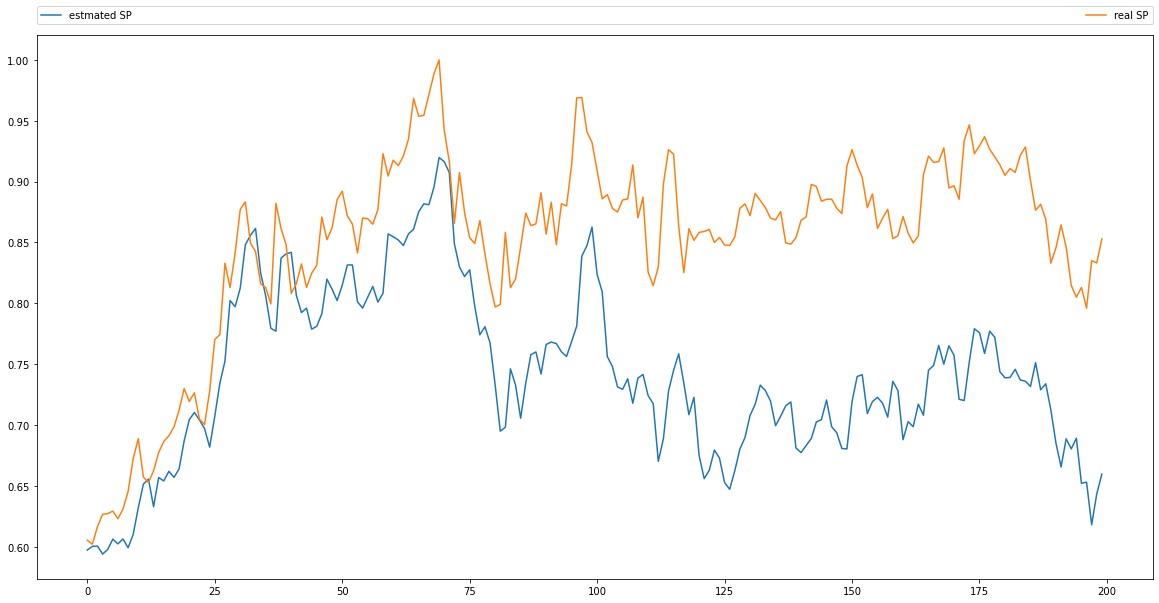

In [6]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [7]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.11041541265732198
RMSE:  0.12741554231352947


# SONY

In [3]:
path = "../032721Comparison/Data/SONY2021.csv"
# Load data
train_x, train_y, test_x, test_y = utils.get_train_and_test_set(
    path, date, count, history_size, training_count
)

(1258, 7)
(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)
(910, 90, 1)
(200, 90, 1)


In [4]:
unit_params = range(30, 60, 5)
filter_params = [2, 4, 8, 16]
kernel_params = [2, 4, 8, 16]
best_config, best_err = cnnlstm.cnnlstm_model_selection(train_x, train_y, unit_params, filter_params, kernel_params)
print(best_config, best_err)

2 2 30 mean val RMSE: 0.052353550134145374
2 2 35 mean val RMSE: 0.07356049473706763
2 2 40 mean val RMSE: 0.03642928633677733
2 2 45 mean val RMSE: 0.04131842324101897
2 2 50 mean val RMSE: 0.1213390446100048
2 2 55 mean val RMSE: 0.0731223991456791
2 4 30 mean val RMSE: 0.028902749009708323
2 4 35 mean val RMSE: 0.05389752118984019
2 4 40 mean val RMSE: 0.08336558351709591
2 4 45 mean val RMSE: 0.04134739484412771
2 4 50 mean val RMSE: 0.08848177091586086
2 4 55 mean val RMSE: 0.09062228574639267
2 8 30 mean val RMSE: 0.06708487373057322
2 8 35 mean val RMSE: 0.04342739810903743
2 8 40 mean val RMSE: 0.07911226524539619
2 8 45 mean val RMSE: 0.027551375925809383
2 8 50 mean val RMSE: 0.04228829877972716
2 8 55 mean val RMSE: 0.10642259870158495
2 16 30 mean val RMSE: 0.03708268650837099
2 16 35 mean val RMSE: 0.040248359036325516
2 16 40 mean val RMSE: 0.04899066127124879
2 16 45 mean val RMSE: 0.04586565991067911
2 16 50 mean val RMSE: 0.046336671275407734
2 16 55 mean val RMSE: 0.1

In [5]:
model = None
gc.collect()

filter_size, kernel_size, unit_count = best_config

model = cnnlstm.cnnlstm_model(test_x, filter_size, kernel_size, unit_count)
model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 7/100
29/29 [==============================] - 0s 5ms/step - loss: 9.8195e-04
Epoch 8/100
29/29 [==============================] - 0s 5ms/step - loss: 8.4612e-04
Epoch 9/100
29/29 [==============================] - 0s 5ms/step - loss: 7.6259e-04
Epoch 10/100
29/29 [==============================] - 0s 5ms/step - loss: 7.1591e-04
Epoch 11/100
29/29 [==============================] - 0s 5ms/step - loss: 6.8042e-04
Epoch 12/100
29/29 [==============================] - 0s 4ms/step - loss: 6.4546e-04
Epoch 13/100


29/29 [==============================] - 0s 4ms/step - loss: 3.1452e-04
Epoch 98/100
29/29 [==============================] - 0s 5ms/step - loss: 3.7149e-04
Epoch 99/100
29/29 [==============================] - 0s 5ms/step - loss: 4.3879e-04
Epoch 100/100
29/29 [==============================] - 0s 5ms/step - loss: 3.4870e-04
Model: "sequential_480"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_960 (Conv1D)          (None, 87, 4)             20        
_________________________________________________________________
conv1d_961 (Conv1D)          (None, 84, 4)             68        
_________________________________________________________________
max_pooling1d_480 (MaxPoolin (None, 42, 4)             0         
_________________________________________________________________
flatten_960 (Flatten)        (None, 168)               0         
______________________________________________________

20723

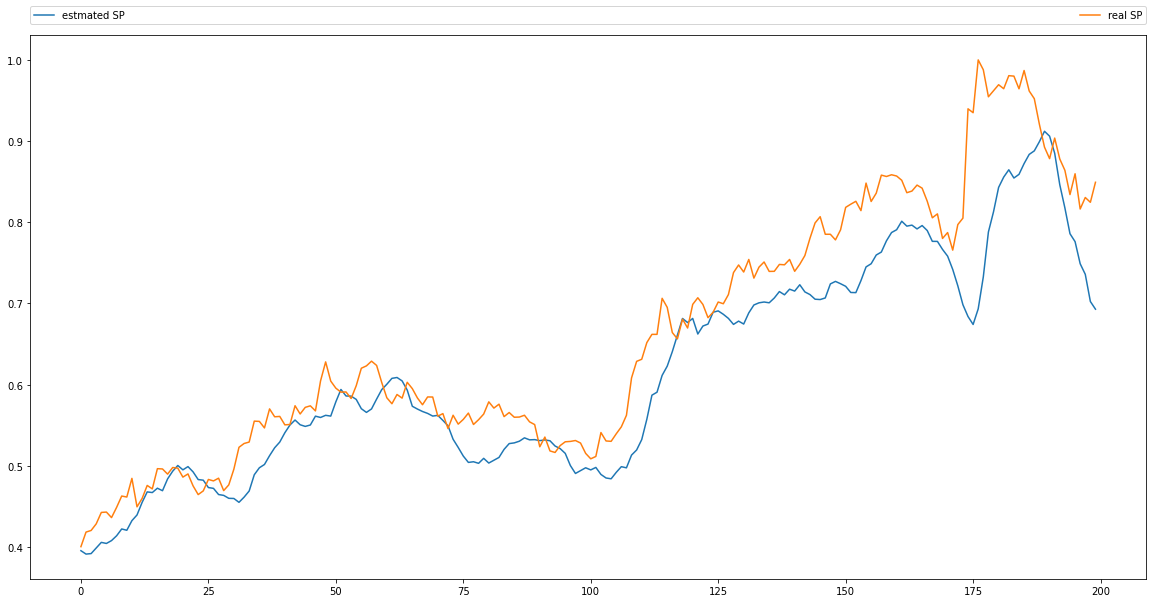

In [6]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [7]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.048299486878188705
RMSE:  0.0668592393977226


# IBIO

In [8]:
path = "../032721Comparison/Data/IBIO2021.csv"
# Load data
train_x, train_y, test_x, test_y = utils.get_train_and_test_set(
    path, date, count, history_size, training_count
)

(1258, 7)
(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)
(910, 90, 1)
(200, 90, 1)


In [9]:
unit_params = range(30, 60, 5)
filter_params = [2, 4, 8, 16]
kernel_params = [2, 4, 8, 16]
best_config, best_err = cnnlstm.cnnlstm_model_selection(train_x, train_y, unit_params, filter_params, kernel_params)
print(best_config, best_err)

2 2 30 mean val RMSE: 0.14828818201544086
2 2 35 mean val RMSE: 0.03515806384059602
2 2 40 mean val RMSE: 0.041584551122498724
2 2 45 mean val RMSE: 0.09021511782798972
2 2 50 mean val RMSE: 0.11202260006734222
2 2 55 mean val RMSE: 0.03763268721564409
2 4 30 mean val RMSE: 0.04314973423974079
2 4 35 mean val RMSE: 0.1012644946015753
2 4 40 mean val RMSE: 0.07247842811238907
2 4 45 mean val RMSE: 0.06006424118460525
2 4 50 mean val RMSE: 0.0629156086365946
2 4 55 mean val RMSE: 0.059071137735326316
2 8 30 mean val RMSE: 0.04955028995080033
2 8 35 mean val RMSE: 0.05559478195799643
2 8 40 mean val RMSE: 0.08622001712981497
2 8 45 mean val RMSE: 0.06538314787487501
2 8 50 mean val RMSE: 0.046039850160670505
2 8 55 mean val RMSE: 0.07062718545569907
2 16 30 mean val RMSE: 0.07651954218629227
2 16 35 mean val RMSE: 0.14534937696699107
2 16 40 mean val RMSE: 0.04893451461549954
2 16 45 mean val RMSE: 0.09732396916243086
2 16 50 mean val RMSE: 0.08955772472418702
2 16 55 mean val RMSE: 0.121

In [10]:
model = None
gc.collect()

filter_size, kernel_size, unit_count = best_config

model = cnnlstm.cnnlstm_model(test_x, filter_size, kernel_size, unit_count)
model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 8/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 12/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 13/100
29/29 [=================

29/29 [==============================] - 0s 4ms/step - loss: 4.1251e-04
Epoch 99/100
29/29 [==============================] - 0s 4ms/step - loss: 4.2210e-04
Epoch 100/100
29/29 [==============================] - 0s 4ms/step - loss: 4.1711e-04
Model: "sequential_961"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1922 (Conv1D)         (None, 89, 8)             24        
_________________________________________________________________
conv1d_1923 (Conv1D)         (None, 88, 8)             136       
_________________________________________________________________
max_pooling1d_961 (MaxPoolin (None, 44, 8)             0         
_________________________________________________________________
flatten_1922 (Flatten)       (None, 352)               0         
_________________________________________________________________
repeat_vector_961 (RepeatVec (None, 1, 352)            0         
_______

20723

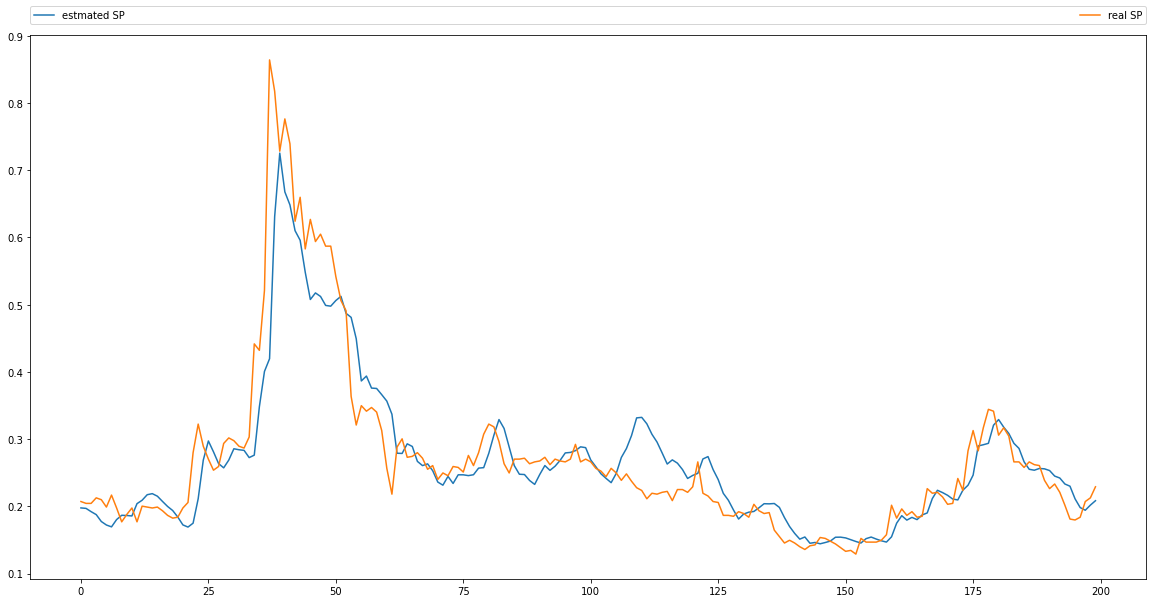

In [11]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [12]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.03184443758726529
RMSE:  0.05416150824693337
